## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw, last update: 06-06-2024

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations: polar coordinates from beacon

In the middle of a training area, there is a beacon that reports range and angle to the robot. This will allow it to infer its position in the field through a polar-to-cartesian transformation:

$$\begin{align}
y_{1,k} &= g_1(z_k) = \sqrt{x_{1,k}^2 + x_{2,k}^2} \\
y_{2,k} &= g_2(z_k) = \mathrm{atan}(x_{1,k}, x_{2,k}) \, ,
\end{align}$$

where $\mathrm{atan}$ refers to the arctangent. We denote this as:

$$y_k = g(z_k) + r_k$$

where $r_k$ is measurement noise. 

### Probabilistic model

The above system can be captured with a probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

### Posterior predictive

$$\begin{align}
p(y_k \mid y_{1:k-1}) &= \int p(y_k \mid z_k) p(z_k \mid y_{1:k-1}) dz_k \\
&= \int \mathcal{N} \big(\begin{bmatrix} z_k \\ y_k \end{bmatrix} \mid \begin{bmatrix} m_k \\ \mu_k \end{bmatrix}, \begin{bmatrix} S_k & \Gamma_k \\ \Gamma_k^{\top} & \Sigma_k \end{bmatrix} \big) dz_k \\
&= \mathcal{N}(y_k \mid \mu_k, \Sigma_k)
\end{align}$$

### Planning and control

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{aligned}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{aligned}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{aligned}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(s|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{aligned}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{aligned}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{aligned}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{aligned}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{aligned}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi R - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{aligned}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{aligned}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{aligned}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{aligned}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

## Experiments

In [63]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using Revise
using Colors
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=15Plots.pt)
includet("../Robots.jl"); using. Robots
includet("../FreeEnergyAgents.jl"); using. FreeEnergyAgents
includet("../util.jl");

  Activating project at `c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations`


In [76]:
# Time
Δt = 0.2
len_trial = 20
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 5;

# Nonlinear observation
g(x::AbstractVector) = [sqrt(x[1]^2 + x[2]^2), atan(x[2],x[1])]

# Setpoint (desired observation)
z_star = [0.0, .5, 0.0, 0.0]
goal = (g(z_star), 0.5diagm(ones(2)))

# Parameters
σ = 1e-3
ρ = [1e-3, 1e-3]
η = 0.0

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Initial state
z_0 = [0.0, -.5, 0., 0.]

# Initial belief
m_0 = z_0
S_0 = 0.1diagm(ones(4));

fbot  = FieldBot(g, ρ, σ=σ, Δt=Δt, control_lims=u_lims)
agent = EFEAgent(goal, g, ρ, σ=σ; η=η, Δt=Δt, time_horizon=len_horizon)

EFEAgent(4, 2, 2, 0.2, g, [1.0 0.0 0.2 0.0; 0.0 1.0 0.0 0.2; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [0.0 0.0; 0.0 0.0; 0.2 0.0; 0.0 0.2], [2.6666666666666677e-6 0.0 2.0000000000000005e-5 0.0; 0.0 2.6666666666666677e-6 0.0 2.0000000000000005e-5; 2.0000000000000005e-5 0.0 0.0002 0.0; 0.0 2.0000000000000005e-5 0.0 0.0002], [1.0e-6 0.0; 0.0 1.0e-6], 0.0, ([0.5, 1.5707963267948966], [0.5 0.0; 0.0 0.5]), 5)

### Model: EFE (ET2)

In [77]:
# Preallocate
z_est  = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln  = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln  = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim  = zeros(4,len_trial)
y_sim  = zeros(2,len_trial)
u_sim  = zeros(2,len_trial)
F_EFE2 = zeros(len_trial)
J_EFE2 = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "State estimation"
    
    m_k_pred, S_k_pred = predict(agent, m_kmin1, S_kmin1, u_sim[:,k-1])
    m_k,S_k = correct(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
    
    # Compute model evidence
    F_EFE2[k] = evidence(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
    J_EFE2[k] = -logpdf(MvNormal(goal[1], goal[2]), y_sim[:,k])
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(agent, u, (m_k,S_k), approx="ET2")
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(2*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    u_sim[:,k] = policy[:,1]

    # Planning
    planned_states, planned_obs = planned_trajectory(agent, policy, (m_k,S_k), approx="ET2")
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


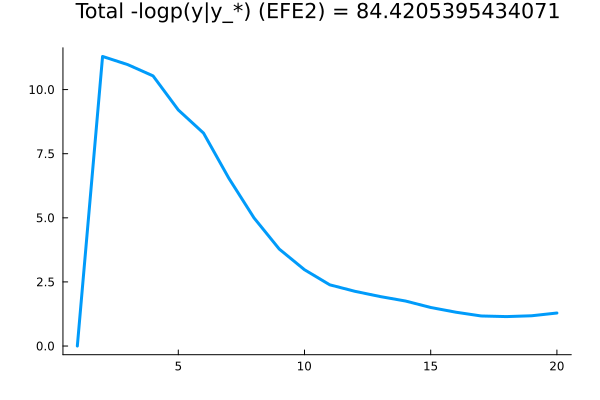

In [78]:
tJ_EFE2 = sum(J_EFE2)
plot(J_EFE2, title="Total -logp(y|y_*) (EFE2) = $tJ_EFE2")

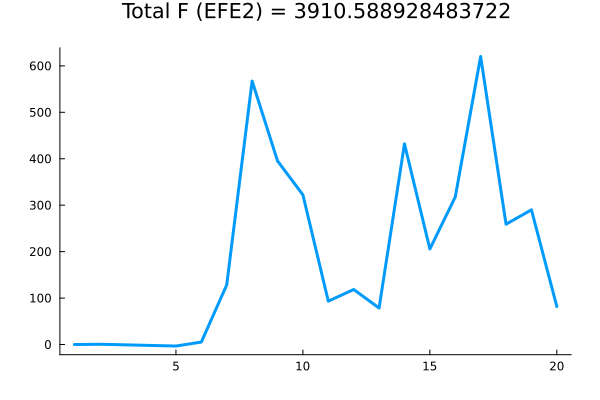

In [79]:
tF_EFE2 = sum(F_EFE2)
plot(F_EFE2, title="Total F (EFE2) = $tF_EFE2")

In [68]:
# k = 9

# m_k = z_est[1][:,k]
# S_k = z_est[2][:,:,k]

# μ, Σ, Γ = ET2(m_k, S_k, agent.g, addmatrix=agent.R, forceHermitian=true)
# -logpdf(MvNormal(μ, Matrix(Σ)), y_sim[:,k])

# contourf(range(0.4,.55, length=100), range(-.3,-.1, length=100), (x,y) -> -logpdf(MvNormal(μ, Matrix(Σ)), [x,y]))
# scatter!([y_sim[1,k]], [y_sim[2,k]], color="green")

In [69]:
# k = 10

# m_k = z_est[1][:,k]
# S_k = z_est[2][:,:,k]

# μ, Σ, Γ = ET2(m_k, S_k, agent.g, addmatrix=agent.R, forceHermitian=true)
# -logpdf(MvNormal(μ, Matrix(Σ)), y_sim[:,k])

# contourf(range(0.4,.55, length=100), range(-.3,-.1, length=100), (x,y) -> -logpdf(MvNormal(μ, Matrix(Σ)), [x,y]))
# scatter!([y_sim[1,k]], [y_sim[2,k]], color="green")

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations\animations\cart2polar-experiment-EFE2-path.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\animations\\cart2polar-experiment-EFE2-path.gif")
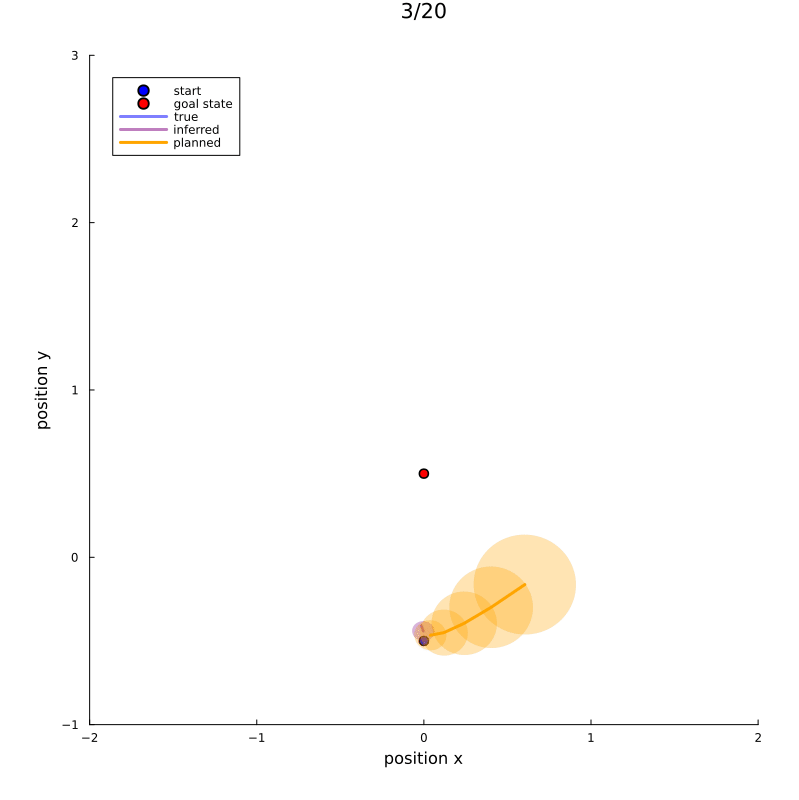

In [80]:
xl = [-2., 2.]
yl = [-1., 3.]

anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), title="$k/$len_trial", legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)    
    
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)

    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "animations/cart2polar-experiment-EFE2-path.gif", fps=3)

In [40]:
# function helper(x,y; R=diagm(ones(2)), S_t=diagm(ones(2)))

#     # Unscented transform moments
#     μ, Σ, Γ = ET2([x; y], S_t, agent.g, addmatrix=R, forceHermitian=true)

#     # Calculate ambiguity
#     return risk(μ,Σ, goal) + ambiguity(Σ,Γ, S_t)

# end

# xr = range(xl[1], stop=xl[2], length=50)
# yr = range(yl[1], stop=yl[2], length=50)


# anim = @animate for k in 3:len_trial

#     p301 = plot(size=(800,800), title="$k/$len_trial", legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)

#     contourf!(xr,yr, (xr,yr) -> helper(xr,yr; R=agent.R, S_t=z_est[2][1:2,1:2,k]), nlevels=20, linewidth=0, clims=(0., 40.))

#     scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
#     scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
#     plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)    
    
#     plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
#     covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)

#     plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
#     for j in 1:len_horizon
#         covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
#     end
# end
# gif(anim, "animations/cart2polar-experiment-EFE2-path+EFE.gif", fps=3)

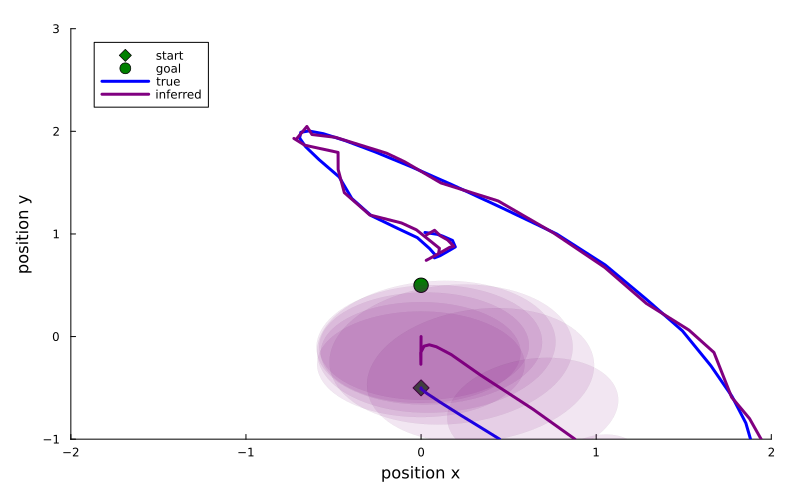

In [41]:

p301 = plot(size=(800,500), legend=:topleft, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([z_0[1]], [z_0[2]], color="green", marker=:diamond, label="start", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=8)

plot!(z_sim[1,:], z_sim[2,:], c="blue", label="true")    
plot!(z_est[1][1,:], z_est[1][2,:], c="purple", label="inferred")

for j in 1:len_trial
    covellipse!(z_est[1][1:2,j], z_est[2][1:2,1:2,j], n_std=1, color="purple", linewidth=0, fillalpha=0.1)
end
plot!()

In [42]:
savefig("figures/cart2polar-experiment-EFE2-path.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-experiment-EFE2-path.png"

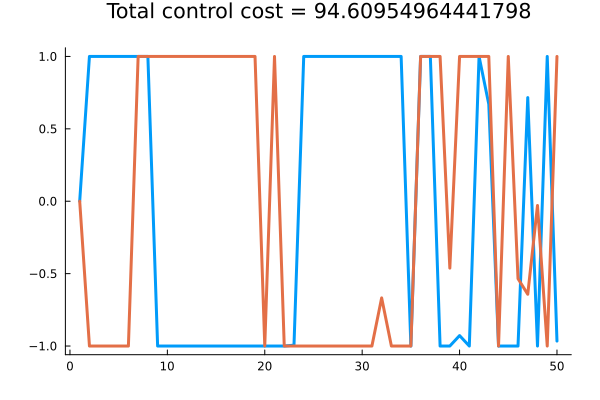

In [43]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")

### Model: EFE (ET1)

In [44]:
# Preallocate
z_est  = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln  = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln  = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim  = zeros(4,len_trial)
y_sim  = zeros(2,len_trial)
u_sim  = zeros(2,len_trial)
F_EFE1 = zeros(len_trial)
J_EFE1 = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(2len_horizon)

μ = zeros(2)  
Σ = zeros(2,2)
Γ = zeros(2,4)

@showprogress for k in 2:len_trial
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "State estimation"
    
    m_k_pred, S_k_pred = predict(agent, m_kmin1, S_kmin1, u_sim[:,k-1])
    m_k,S_k = correct(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET1")
    
    # Compute model evidence
    F_EFE1[k] = evidence(agent, y_sim[:,k], m_k, S_k, approx="ET2")
    J_EFE1[k] = -logpdf(MvNormal(goal[1], goal[2]), y_sim[:,k])
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(agent, u, (m_k,S_k), approx="ET1")
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(2*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    u_sim[:,k] = policy[:,1]

    # Planning
    planned_states, planned_obs = planned_trajectory(agent, policy, (m_k,S_k), approx="ET1")
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress:  27%|███████████                              |  ETA: 0:00:36┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\Wouter Kouw\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148
Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


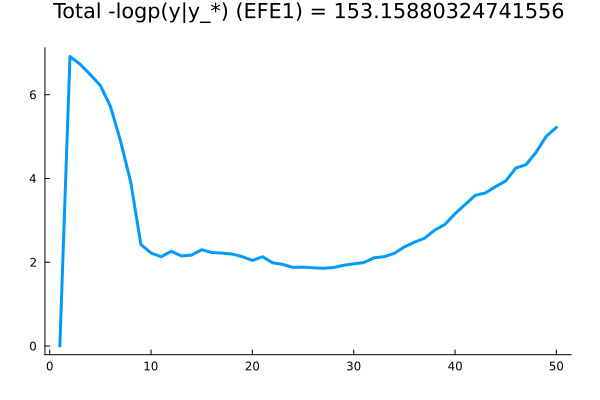

In [45]:
tJ_EFE1 = sum(J_EFE1)
plot(J_EFE1, title="Total -logp(y|y_*) (EFE1) = $tJ_EFE1")

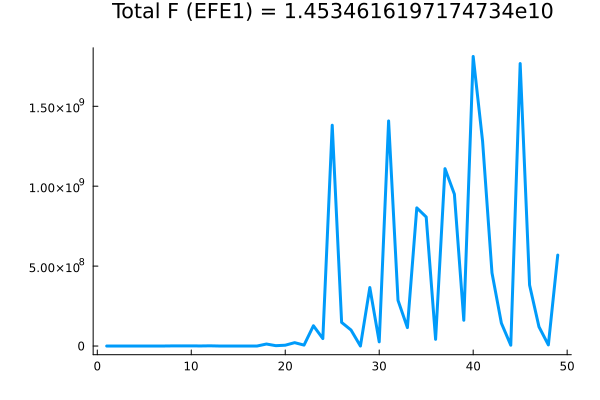

In [46]:
tF_EFE1 = sum(F_EFE1)
plot(F_EFE1[2:end], title="Total F (EFE1) = $tF_EFE1")

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations\animations\cart2polar-experiment-EFE1-path.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\animations\\cart2polar-experiment-EFE1-path.gif")
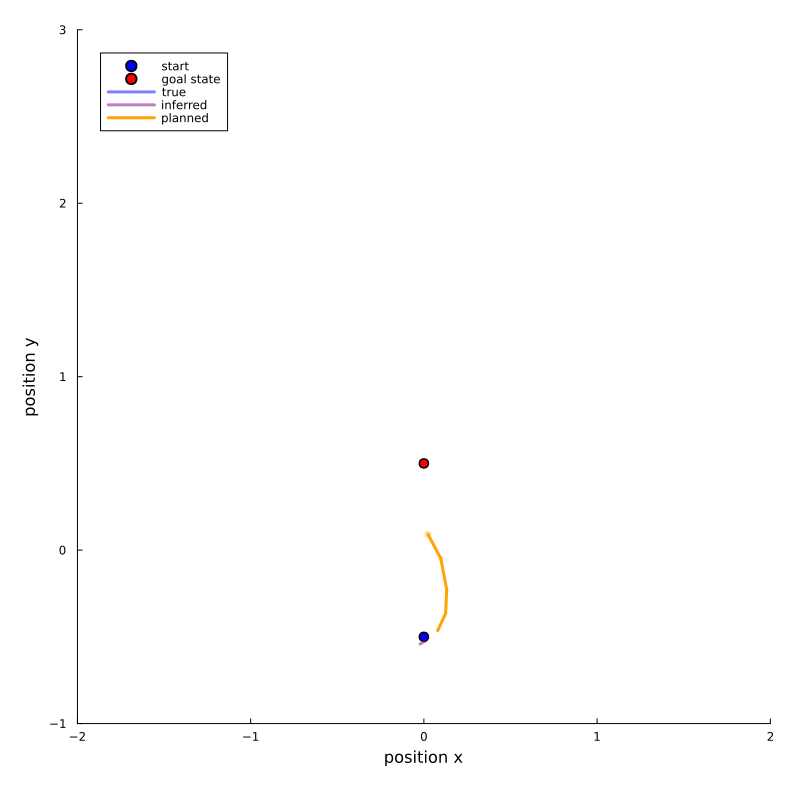

In [47]:
anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)
    
    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "animations/cart2polar-experiment-EFE1-path.gif", fps=3) 

In [48]:
# function helper(x,y; R=diagm(ones(2)), S_t=diagm(ones(2)))

#     # Unscented transform moments
#     μ, Σ, Γ = ET1([x; y], S_t, agent.g, addmatrix=R, forceHermitian=true)

#     # Calculate ambiguity
#     return risk(μ,Σ, goal) + ambiguity(Σ,Γ, S_t)

# end

# xr = range(xl[1], stop=xl[2], length=50)
# yr = range(yl[1], stop=yl[2], length=50)


# anim = @animate for k in 3:len_trial

#     p301 = plot(size=(800,800), title="$k/$len_trial", legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)

#     contourf!(xr,yr, (xr,yr) -> helper(xr,yr; R=agent.R,S_t=z_est[2][1:2,1:2,k]), nlevels=10, linewidth=0, clims=(0., 10.))

#     scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
#     scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
#     plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)    
    
#     plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
#     covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)

#     plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
#     for j in 1:len_horizon
#         covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
#     end
# end
# gif(anim, "animations/cart2polar-experiment-EFE1-path+EFE.gif", fps=3)

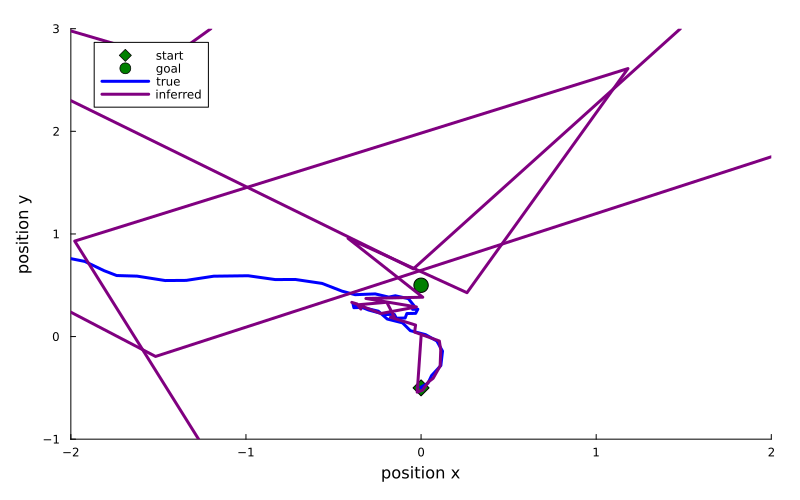

In [49]:
p301 = plot(size=(800,500), legend=:topleft, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([z_0[1]], [z_0[2]], color="green", marker=:diamond, label="start", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=8)

plot!(z_sim[1,:], z_sim[2,:], c="blue", label="true")    
plot!(z_est[1][1,:], z_est[1][2,:], c="purple", label="inferred")

for j in 1:len_trial
    covellipse!(z_est[1][1:2,j], z_est[2][1:2,1:2,j], n_std=1, color="purple", linewidth=0, fillalpha=0.1)
end
plot!()

In [50]:
savefig("figures/cart2polar-experiment-EFE1-path.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-experiment-EFE1-path.png"

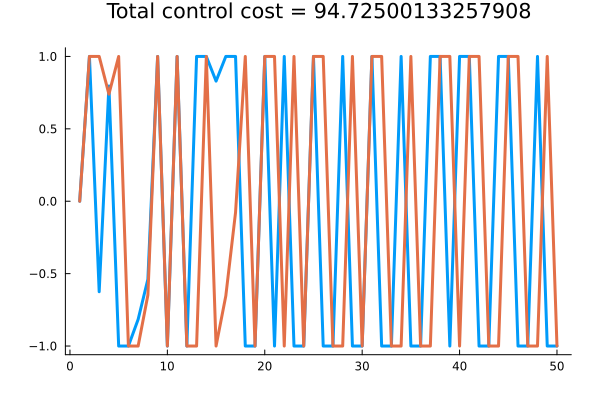

In [51]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")

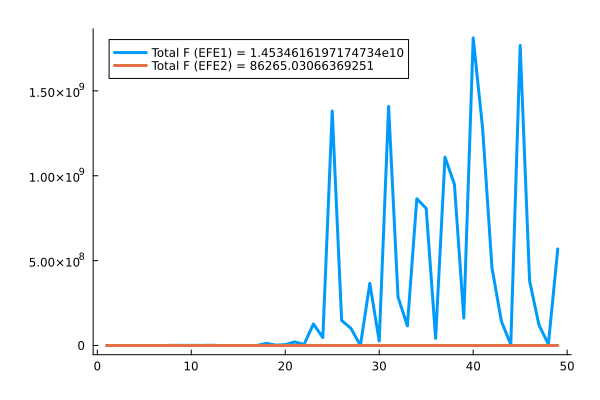

In [52]:
plot()
plot!(F_EFE1[2:end], label="Total F (EFE1) = $tF_EFE1")
plot!(F_EFE2[2:end], label="Total F (EFE2) = $tF_EFE2")

### Model: EFER (ET2 risk only)

In [53]:
# Preallocate
z_est  = (zeros(4,len_trial), zeros(4,4,len_trial))
z_pln  = (zeros(len_trial, 4,len_horizon), zeros(len_trial, 4,4,len_horizon))
y_pln  = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
z_sim  = zeros(4,len_trial)
y_sim  = zeros(2,len_trial)
u_sim  = zeros(2,len_trial)
F_EFER = zeros(len_trial)
J_EFER = zeros(len_trial)

# Initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

# Initialize policy
policy = zeros(2len_horizon)

μ = zeros(2)  
Σ = zeros(2,2)
Γ = zeros(2,4)

@showprogress for k in 2:len_trial
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "State estimation"
    
    m_k_pred, S_k_pred = predict(agent, m_kmin1, S_kmin1, u_sim[:,k-1])
    m_k,S_k = correct(agent, y_sim[:,k], m_k_pred, S_k_pred, approx="ET2")
    
    # Compute model evidence
    F_EFER[k] = evidence(agent, y_sim[:,k], m_k, S_k, approx="ET2")
    J_EFER[k] = -logpdf(MvNormal(goal[1], goal[2]), y_sim[:,k])
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(agent, u, (m_k,S_k), approx="ET2", add_ambiguity=false)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(2*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = reshape(Optim.minimizer(results), (2,len_horizon))
    u_sim[:,k] = policy[:,1]

    # Planning
    planned_states, planned_obs = planned_trajectory(agent, policy, (m_k,S_k), approx="ET2")
    z_pln[1][k,:,:]   = planned_states[1]
    z_pln[2][k,:,:,:] = planned_states[2] 
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


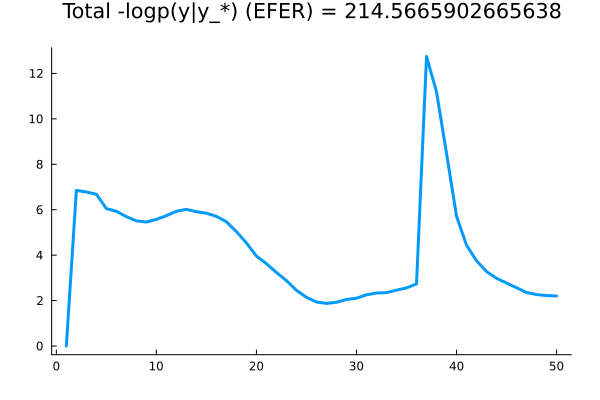

In [54]:
tJ_EFER = sum(J_EFER)
plot(J_EFER, title="Total -logp(y|y_*) (EFER) = $tJ_EFER")

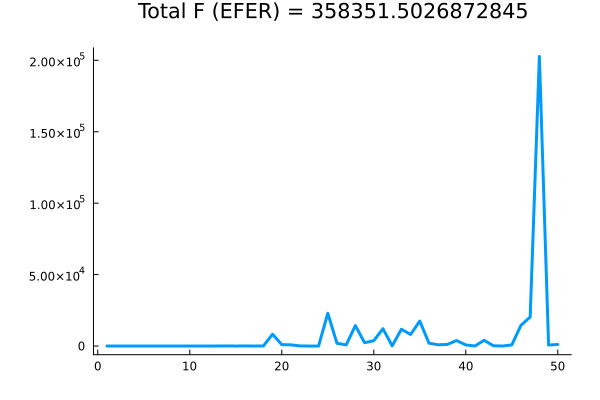

In [55]:
tF_EFER = sum(F_EFER)
plot(F_EFER, title="Total F (EFER) = $tF_EFER")

┌ Info: Saved animation to c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\IWAI2024-ambiguity\demonstrations\animations\cart2polar-experiment-EFER-path.gif
└ @ Plots C:\Users\Wouter Kouw\.julia\packages\Plots\QWCV6\src\animation.jl:156


Plots.AnimatedGif("c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\animations\\cart2polar-experiment-EFER-path.gif")
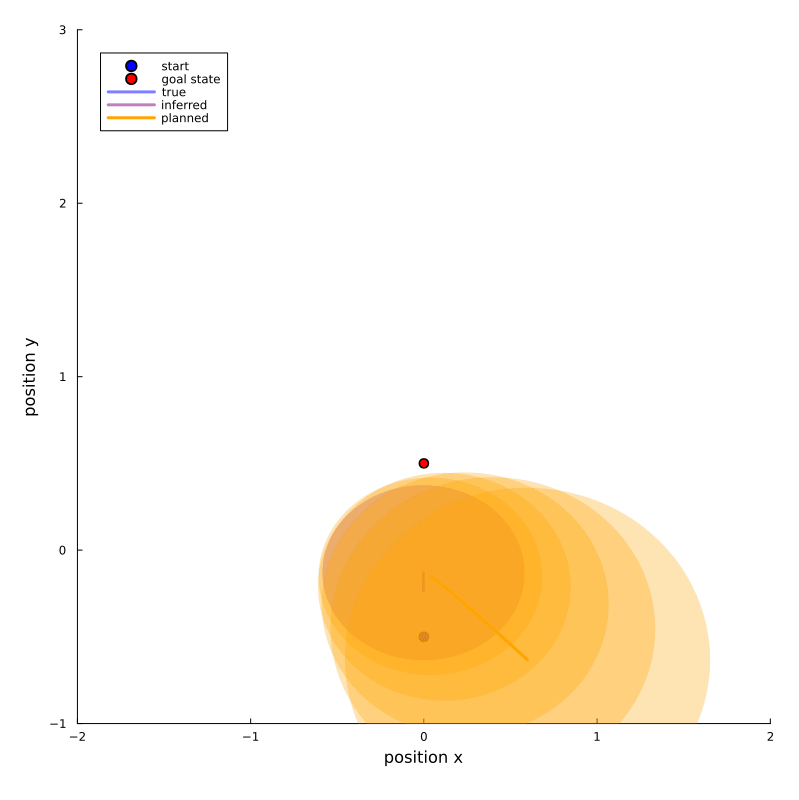

In [56]:
anim = @animate for k in 3:len_trial
    p301 = plot(size=(800,800), legend=:topleft, aspect_ratio=:equal, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
    scatter!([z_0[1]], [z_0[2]], color="blue", label="start", markersize=5)
    scatter!([z_star[1]], [z_star[2]], color="red", label="goal state", markersize=5)
    
    plot!(z_sim[1,2:k], z_sim[2,2:k], c="blue", label="true", alpha=0.5)
    plot!(z_est[1][1,2:k], z_est[1][2,2:k], c="purple", label="inferred", alpha=0.5)
    covellipse!(z_est[1][1:2,k], z_est[2][1:2,1:2,k], n_std=1, color="purple", linewidth=0, fillalpha=0.3)
    
    plot!(z_pln[1][k,1,:], z_pln[1][k,2,:], c="orange", label="planned")
    for j in 1:len_horizon
        covellipse!(z_pln[1][k,1:2,j], z_pln[2][k,1:2,1:2,j], n_std=1, color="orange", linewidth=0, fillalpha=0.3)
    end
end
gif(anim, "animations/cart2polar-experiment-EFER-path.gif", fps=3) 

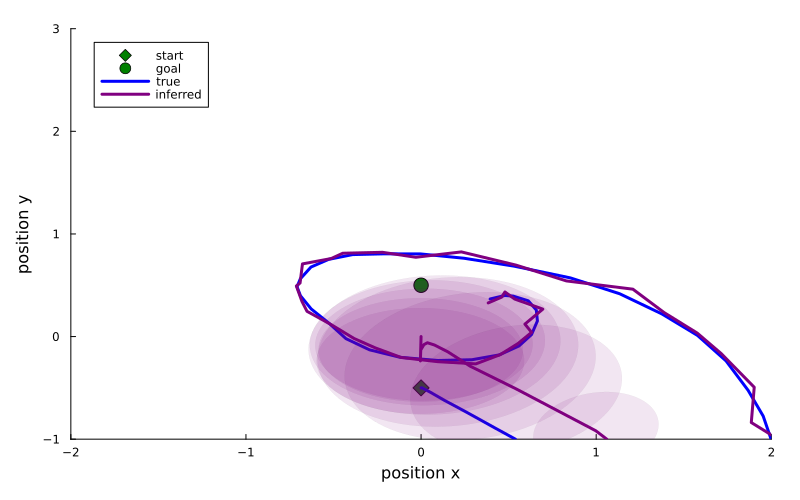

In [57]:
p301 = plot(size=(800,500), legend=:topleft, ylabel="position y", xlabel="position x", xlims=xl, ylims=yl)
scatter!([z_0[1]], [z_0[2]], color="green", marker=:diamond, label="start", markersize=8)
scatter!([z_star[1]], [z_star[2]], color="green", label="goal", markersize=8)

plot!(z_sim[1,:], z_sim[2,:], c="blue", label="true")    
plot!(z_est[1][1,:], z_est[1][2,:], c="purple", label="inferred")

for j in 1:len_trial
    covellipse!(z_est[1][1:2,j], z_est[2][1:2,1:2,j], n_std=1, color="purple", linewidth=0, fillalpha=0.1)
end
plot!()

In [58]:
savefig("figures/cart2polar-experiment-EFER-path.png")

"c:\\Syndr\\Wouter\\Onderzoek\\Projecten\\tue\\efe-planning\\IWAI2024-ambiguity\\demonstrations\\figures\\cart2polar-experiment-EFER-path.png"

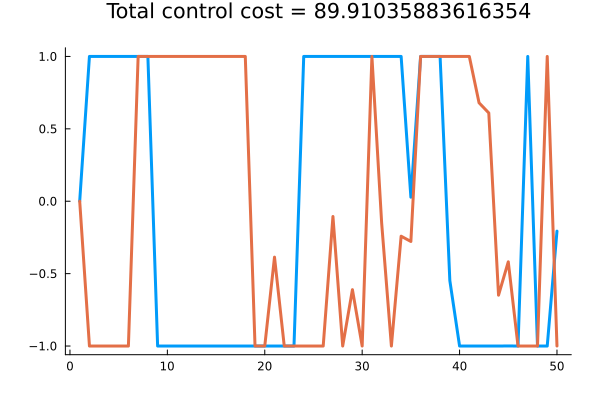

In [59]:
tU = sum(abs.(u_sim[:]))
plot(u_sim', title="Total control cost = $tU")

### Comparison

In [60]:
println("F EFE2 = $tF_EFE2")
println("F EFE1 = $tF_EFE1")
println("F EFER = $tF_EFER")

F EFE2 = 86265.03066369251
F EFE1 = 1.4534616197174734e10
F EFER = 358351.5026872845


In [62]:
tJ_EFE2 = sum(J_EFE2)
tJ_EFE1 = sum(J_EFE1)
tJ_EFER = sum(J_EFER)

println("Total goal prior -log-likelihood EFE2 = $tJ_EFE2")
println("Total goal prior -log-likelihood EFE1 = $tJ_EFE1")
println("Total goal prior -log-likelihood EFER = $tJ_EFER")

Total goal prior -log-likelihood EFE2 = 182.95075533468327
Total goal prior -log-likelihood EFE1 = 153.15880324741556
Total goal prior -log-likelihood EFER = 214.5665902665638


In [61]:
perf_EFE2 = sum(F_EFE2) + sum(J_EFE2)
perf_EFE1 = sum(F_EFE1) + sum(J_EFE1)
perf_EFER = sum(F_EFER) + sum(J_EFER)

println("Performance EFE2 = $perf_EFE2")
println("Performance EFE1 = $perf_EFE1")
println("Performance EFER = $perf_EFER")

Performance EFE2 = 86447.98141902719
Performance EFE1 = 1.4534616350333538e10
Performance EFER = 358566.069277551
